# Calibration

**Author(s):**
 - Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

**Description:**

This notebook contains DL1-calibration plots and benchmark proposals for the _protopipe_ pipeline.  
This was mainly triggered by the step-by-step comparison against _CTA-MARS_, but it can be extended to other pipelines as well.  
**NOTE** Let's try to follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding those benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need an _images.h5_ file which can be generated using _write_dl1.py_ .  
Reference simtel-file, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines) until we have a more automatic and fancy approach (aka [cta-benchmarks](https://github.com/cta-observatory/cta-benchmarks)+[ctaplot](https://github.com/cta-observatory/ctaplot)).  

The data format required to run the notebook is the current one used by _protopipe_ . Later on it will be the same as in _ctapipe_ .  
**WARNING:** Mono-telescope images (2 triggers - 1 image or 1 trigger - 1 image) are not currently taken into account by the publicly available development version (the new DL1 script will have them automatically, so I decided to skip this feature in protopipe), until then expect a somewhat lower statistics.

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings). The file used shouud always be _gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz_ until Prod5.

**TODO:**  
* manage all cameras depending on input data
* decide what to do with calibScale (either move to code, or remove altogether)
* update input data whith ctapipe 0.8 is released (DL1 data format frozen)
* ...

## Imports

In [1]:
import os
from pathlib import Path

import numpy as np
from scipy.stats import percentileofscore
import tables
import uproot
from astropy.io import ascii

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from ctapipe.io import event_source
from ctapipe.instrument import CameraGeometry

/Users/michele/anaconda3/envs/protopipe/lib/python3.7/site-packages/corsikaio/subblocks/dtypes.py:20: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dict(**dt))


## Functions

### Add statistical information to a plot

In [2]:
def add_stats(data, ax, x = 0.70, y = 0.85, color = "black"):
    """Add a textbox containing statistical information."""
    mu = data.mean()
    median = np.median(data)
    sigma = data.std()
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(x, y, 
            textstr, 
            transform=ax.transAxes, 
            fontsize=10,
            horizontalalignment='left',
            verticalalignment='center', 
            bbox=props,
            color=color)

### Spectral weight from requirement B-TEL-1010 "Intensity Resolution"

In [3]:
def apply_weight_BTEL1010(tel_data):
    """Define the weights from requirement B-TEL-1010-Intensity Resolution."""
    target_slope = -2.62 # this is the spectral slope as required by the B-TEL-1010 "Intensity Resolution" doc
    spec_slope = -2.0 # this is the spectral slope in the simtel files
    energies = tel_data.col("mc_energy")*1.e3 # GeV
    # each image array needs the same weight
    weights = np.repeat(np.power(energies/200., target_slope - spec_slope), 1855)
    return weights.ravel()

### Calculation of the bias

In [4]:
def calc_bias(x_bin_edges, y_bin_edges, hist):
    """Calculate the average bias of charge resolution from 50 to 500 true photoeletrons.
    These limits are chosen in order to be safely away from saturation and from NSB noise.
    
    Parameters
    ----------
    x_bin_edges : 1D array
        Bin edges in true photoelectrons.
    y_bin_edges : 1D array
        Bin edges in reconstructed/true photoelectrons.
    hist : 2D array
        The full histogram of reconstructed/true against true photoelectrons.
        
    Returns
    -------
    bias : float
        Average bias of charge resolution from 50 to 500 true photoelectrons.
    
    """
    min_edge_index = np.digitize(1.7, x_bin_edges) - 1
    max_edge_index = np.digitize(2.7, x_bin_edges)

    proj = np.zeros(600)
    for i in range(min_edge_index, max_edge_index + 1):
        proj = proj + hist[i]

    y_bin_centers = 0.5*(y_bin_edges[1:] + y_bin_edges[:-1])

    bias = 1./np.average(y_bin_centers, weights = proj)
    
    return bias

### Root Mean Square around 1

In [5]:
def calc_rms(values, weights):
    """Root Mean Square around 1 as proposed from comparison with CTA-MARS.
    
    The input values are vertical slices of the 2D histogram showing the bias-corrected charge resolution.
        
    Parameters
    ----------
    values : 1D array
        Values in reconstructed / true photoelectrons corrected for average bias.
    weights : 1D array
        Counts in a cell from the weigthed histogram.
    
    Returns
    -------
    rms : float
        Root Mean Square of around 1 for a vertical slice.
    
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    standard_deviation = np.sqrt(variance)
    a = np.power(standard_deviation,2)
    b = np.power(average-1,2)
    rms = np.sqrt(a+b)
    return rms

# missing errors (err_rms)

### Load the base data file or reset it if overwritten

In [6]:
def load_reset_simtel(indir = "./", fileName = "gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz", max_events=None, config="test"):
    """(Re)load the simtel file for all events and telescopes."""
    source = event_source(input_url=f"{indir}/{fileName}", max_events=max_events)
    suffix = config # all generated plots will have this as a suffix in their name
    return source, suffix

def load_reset_images(indir = "./", fileName = "images.h5", config="test"):
    """(Re)load the file containing the images and extract the data per telescope type."""
    # load DL1 images
    data = tables.open_file(f"{indir}/{fileName}")
    data_LST = data.get_node("/images_LSTCam")
    data_MST = data.get_node("/images_NectarCam")
    suffix = config # all generated plots will have this as a suffix in their name
    return data_LST, data_MST, suffix

## Load data

First we check if a _plots_ folder exists already.  
If not, we create it.

In [7]:
Path("./plots_calibration").mkdir(parents=True, exist_ok=True)

### Requirements

#### B-TEL-1010 (converted in photolectrons)

**Note:** this requirement takes into account Poissonian fluctuations, which in turn are not taken into account in this version of the benchmarks.

In [8]:
photons = np.array([4.08996, 4.27598 , 4.47047 , 4.67381 , 4.88639 , 5.10864 , 5.341   , 5.58393 , 5.83791 , 6.10344 , 6.38105 , 6.67128 , 6.97472 , 7.29196 , 7.62362 , 7.97038 , 8.3329  , 8.71191 , 9.10816 , 9.52244 , 9.95555 , 10.4084 , 10.8818 , 11.3767 , 11.8942 , 12.4352 , 13.0008 , 13.5921 , 14.2103 , 14.8567 , 15.5324 , 16.2389 , 16.9775 , 17.7497 , 18.557  , 19.4011 , 20.2835 , 21.2061 , 22.1706 , 23.179  , 24.2333 , 25.3355 , 26.4879 , 27.6926 , 28.9522 , 30.2691 , 31.6458 , 33.0852 , 34.59   , 36.1633 , 37.8082 , 39.5278 , 41.3257 , 43.2054 , 45.1705 , 47.225  , 49.373  , 51.6187 , 53.9665 , 56.4211 , 58.9874 , 61.6704 , 64.4754 , 67.4079 , 70.4739 , 73.6793 , 77.0306 , 80.5342 , 84.1972 , 88.0268 , 92.0306 , 96.2166 , 100.593 , 105.168 , 109.952 , 114.953 , 120.181 , 125.648 , 131.362 , 137.337 , 143.584 , 150.115 , 156.943 , 164.081 , 171.544 , 179.346 , 187.504 , 196.032 , 204.948 , 214.27  , 224.016 , 234.205 , 244.858 , 255.995 , 267.639 , 279.812 , 292.539 , 305.844 , 319.755 , 334.299 , 349.504 , 365.401 , 382.021 , 399.397 , 417.563 , 436.555 , 456.412 , 477.171 , 498.875 , 521.565 , 545.288 , 570.09  , 596.02  , 623.129 , 651.472 , 681.103 , 712.082 , 744.47  , 778.332 , 813.733 , 850.745 , 889.44  , 929.896 , 972.191 , 1016.41 , 1062.64 , 1110.97 , 1161.5  , 1214.33 , 1269.57 , 1327.31 , 1387.68 , 1450.8  , 1516.79 , 1585.78 , 1657.9  , 1733.31 , 1812.15 , 1894.57 , 1980.75 , 2070.84 , 2165.03 , 2263.5  , 2366.46 , 2474.09 , 2586.62 , 2704.27 , 2827.27 , 2955.87 , 3090.31 , 3230.87 , 3377.82 , 3531.46 , 3692.09 , 3860.02 , 4035.58])
req = np.array([1.98387, 1.91316, 1.84541, 1.78049, 1.71827, 1.65863, 1.60145, 1.54663, 1.49407, 1.44366, 1.3953, 1.34892, 1.30441, 1.26169, 1.22069, 1.18133, 1.14354, 1.10725, 1.07238, 1.03889, 1.0067, 0.975761, 0.946017, 0.917414, 0.889904, 0.863438, 0.83797, 0.813457, 0.789858, 0.767131, 0.745241, 0.72415, 0.703825, 0.684233, 0.665342, 0.647122, 0.629546, 0.612586, 0.596217, 0.580413, 0.565152, 0.550412, 0.53617, 0.522407, 0.509103, 0.49624, 0.483801, 0.471769, 0.460128, 0.448862, 0.437958, 0.427401, 0.417179, 0.407278, 0.397688, 0.388395, 0.379391, 0.370664, 0.362204, 0.354003, 0.34605, 0.338337, 0.330857, 0.323601, 0.316561, 0.309732, 0.303104, 0.296673, 0.290432, 0.284375, 0.278496, 0.272789, 0.267249, 0.261872, 0.256651, 0.251584, 0.246664, 0.241888, 0.237252, 0.232751, 0.228382, 0.224141, 0.220025, 0.21603, 0.212152, 0.208389, 0.204737, 0.201193, 0.197755, 0.19442, 0.191185, 0.188047, 0.185003, 0.182052, 0.179191, 0.176417, 0.173729, 0.171124, 0.168599, 0.166153, 0.163784, 0.16149, 0.159268, 0.157117, 0.155035, 0.15302, 0.151071, 0.149185, 0.147361, 0.145597, 0.143892, 0.142244, 0.140651, 0.139112, 0.137625, 0.13619, 0.134804, 0.133465, 0.132174, 0.130928, 0.129726, 0.128566, 0.127448, 0.12637, 0.125331, 0.124329, 0.123364, 0.122435, 0.12154, 0.120678, 0.119848, 0.119049, 0.11828, 0.117541, 0.116829, 0.116145, 0.115487, 0.114854, 0.114245, 0.113661, 0.113099, 0.112559, 0.11204, 0.111542, 0.111063, 0.110604, 0.110162, 0.109739, 0.109332, 0.108942, 0.108567, 0.108208, 0.107863, 0.107532, 0.107215, 0.106911])

### MonteCarlo data

**IMPORTANT Basic information about the reference simtel file**  
The file used in these benchmarks is  
_gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz_  
and has the following basic features when NO selection is applied,
* number of simulated showers  = 9793
* number of images (LST + MST) = 44401
* min number of triggered telescopes per shower = 2

In [9]:
# load every time you want to plot simtel-related information....
indir = "/Users/michele/Documents/DataAnalysis/CTA/protopipe/tests/comparison_MARS/dev"
infile = "gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz"
source, config = load_reset_simtel(indir=indir,
                                   fileName=infile,
                                  max_events=2, # 2nd event is 1st to trigger both cameras
                                  config="test")

### Protopipe

In [10]:
# fill with the your path, filename of the generated file in your system + config name
data_LST, data_MST, config = load_reset_images(indir="/Users/michele/Documents/DataAnalysis/CTA/protopipe/tests/comparison_MARS/dev",
                                               fileName="images.h5",
                                               config="test")

In [11]:
missing_images = 44401 - len(data_LST.col("mc_phe_image")) - len(data_MST.col("mc_phe_image"))
if missing_images:
    print(f"WARNING: it appears you are missing {missing_images} images!")
    print(f"This corresponds to about {missing_images*100/44401:.0f}% of the total statistics.")
    print("Please, check that:")
    print("* either you have enabled some cuts in analysis.yaml,")
    print("* or you are not considering some events in your analysis when you write to file.")

### CTA-MARS

In [12]:
indir = "/Users/michele/Documents/DataAnalysis/CTA/protopipe/tests/comparison_MARS/CTA-MARS_files"
fileName = "CTA_check_dl1a.root"
path_mars_hists = f"{indir}/{fileName}"

fileName = "IntensityResolution_graphs.root"
path_mars_rms = f"{indir}/{fileName}"

## Prepare data

### protopipe

**Note:** for the moment we do these checks only with LSTCam and NectarCam, but this notebook will be applied to all cameras eventually

In [13]:
# calibScale is placed here momentaneously
calibscale = 0.92

# LSTCam
mc_lst = data_LST.col("mc_phe_image").ravel()
dl1_lst = data_LST.col("dl1_phe_image_1stPass").ravel() / calibscale
calibration_status_lst = np.repeat(data_LST.col("calibration_status"),1855).ravel()
dl1_2ndPass_lst = data_LST.col("dl1_phe_image").ravel() / calibscale
weights_lst = apply_weight_BTEL1010(data_LST)
# NectarCam
mc_mst = data_MST.col("mc_phe_image").ravel()
dl1_mst = data_MST.col("dl1_phe_image_1stPass").ravel() / calibscale
calibration_status_mst = np.repeat(data_MST.col("calibration_status"),1855).ravel()
dl1_2ndPass_mst = data_MST.col("dl1_phe_image").ravel() / calibscale
weights_mst = apply_weight_BTEL1010(data_MST)
# Group
mc_all = [mc_lst, mc_mst]
reco_all = [dl1_lst, dl1_mst]
reco_2ndPass_all = [dl1_2ndPass_lst, dl1_2ndPass_mst]
weights_all = [weights_lst, weights_mst]
calibration_status_all = [calibration_status_lst, calibration_status_mst]

In [14]:
print(f"Total number of pixel-wise values read from simtel file without cuts")
print(f"LSTCam = {len(mc_all[0])}")
print(f"NectarCam = {len(mc_all[1])}")
print(f"'pixel-wise values' means #pixels * #cameras * #events")
print(f"In this phase all single-telescope images are considered.")

Total number of pixel-wise values read from simtel file without cuts
LSTCam = 39381650
NectarCam = 42982205
'pixel-wise values' means #pixels * #cameras * #events
In this phase all single-telescope images are considered.


### CTA-MARS

In [15]:
# from CTA_check_dl1a.root
file_hists = uproot.open(path_mars_hists)
hist2 = file_hists["hist2_type00"]
H2 = hist2.numpy()
# from IntensityResolution_graphs
file_rms = uproot.open(path_mars_rms)
rms_lst = file_rms["IntensityResolution_LST"]
rms_mst = file_rms["IntensityResolution_MST"]
rms = [rms_lst, rms_mst]

## Plots

### R1-level information

#### Pedestals

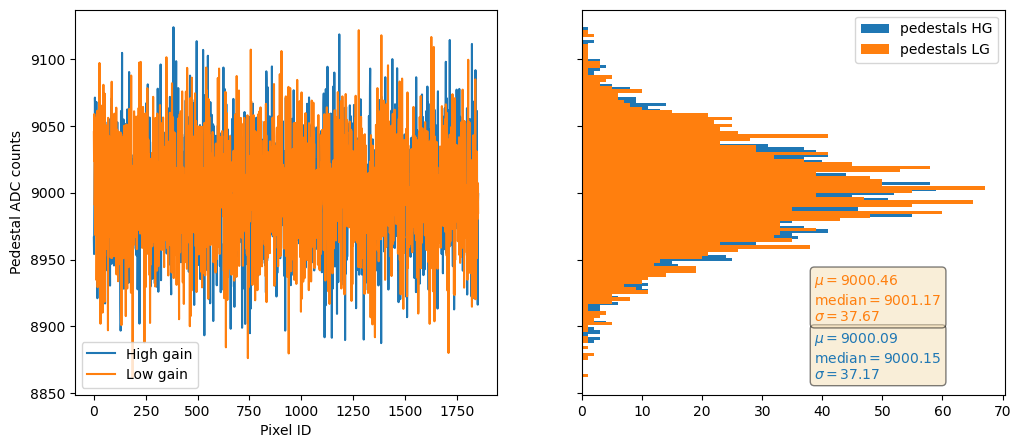

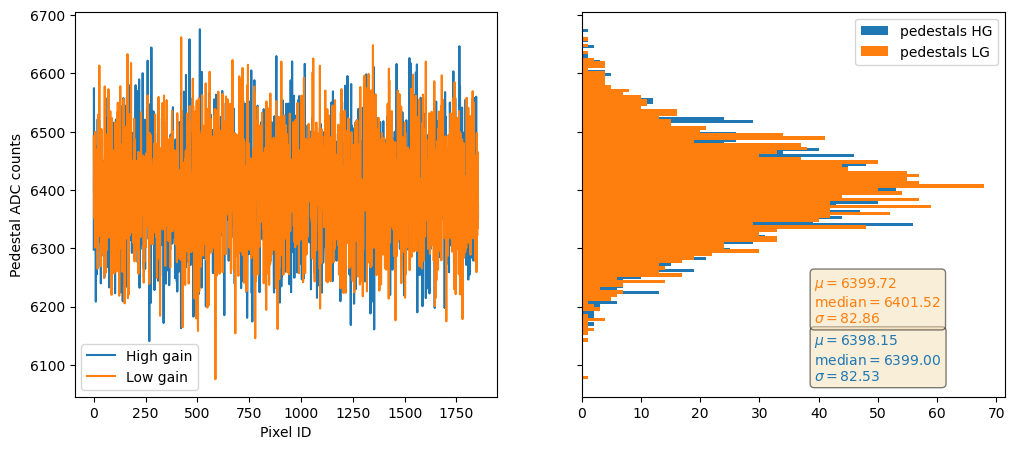

In [16]:
for event in source:
    triggered_telescopes = np.asarray(list(event.r0.tels_with_data))
    if (triggered_telescopes > 5).any() and (triggered_telescopes < 5).any():
        lst_found = 0
        for tel_id in triggered_telescopes:
            cam_id = event.inst.subarray.tel[tel_id].camera.cam_id
            pix_ids = event.inst.subarray.tel[tel_id].camera.pix_id
            pedestals = event.mc.tel[tel_id].pedestal
            if (lst_found == 1) and (cam_id == "LSTCam"):
                continue
            elif (lst_found == 0) and (cam_id == "LSTCam"):
                fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), tight_layout=False, sharey=True)
                ax1.set_xlabel("Pixel ID")
                ax1.set_ylabel("Pedestal ADC counts")
                p1 = ax1.plot(pix_ids, pedestals[1], label="High gain")
                p2 = ax1.plot(pix_ids, pedestals[0], label="Low gain")
                ax2.hist(pedestals[1], bins = 100, orientation="horizontal", label="pedestals HG")
                add_stats(pedestals[1], ax2, x = 0.55, y = 0.10, color = p1[0].get_color())
                ax2.hist(pedestals[0], bins = 100, orientation="horizontal", label="pedestals LG")
                add_stats(pedestals[0], ax2, x = 0.55, y = 0.25, color = p2[0].get_color())
                ax1.legend()
                ax2.legend()
                lst_found = 1
                fig.savefig(f"./plots_calibration/pedestalsVSpixelids_{cam_id}_protopipe_{config}.png")
            elif (lst_found == 1) and (cam_id == "NectarCam"):
                fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), tight_layout=False, sharey=True)
                ax1.set_xlabel("Pixel ID")
                ax1.set_ylabel("Pedestal ADC counts")
                p1 = ax1.plot(pix_ids, pedestals[1], label="High gain")
                p2 = ax1.plot(pix_ids, pedestals[0], label="Low gain")
                ax2.hist(pedestals[1], bins = 100, orientation="horizontal", label="pedestals HG")
                add_stats(pedestals[1], ax2, x = 0.55, y = 0.10, color = p1[0].get_color())
                ax2.hist(pedestals[0], bins = 100, orientation="horizontal", label="pedestals LG")
                add_stats(pedestals[0], ax2, x = 0.55, y = 0.25, color = p2[0].get_color())
                ax1.legend()
                ax2.legend()
                fig.savefig(f"./plots_calibration/pedestalsVSpixelids_{cam_id}_protopipe_{config}.png")
                break

#### DC to PHE

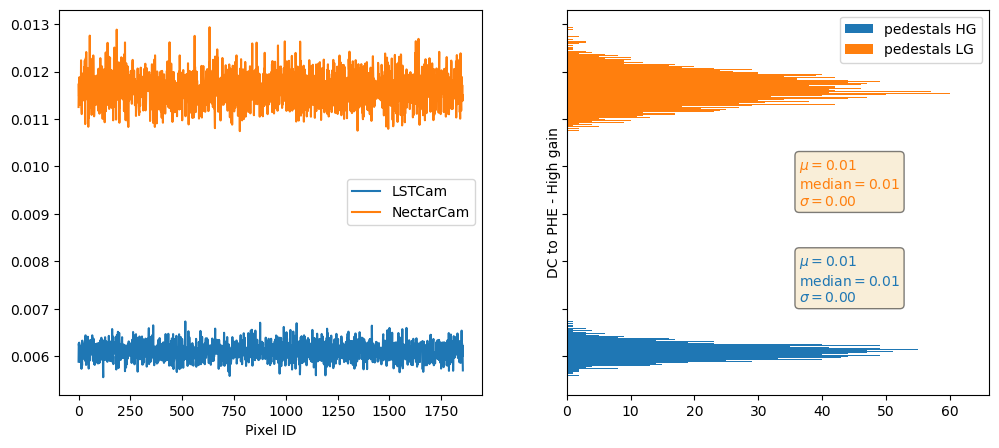

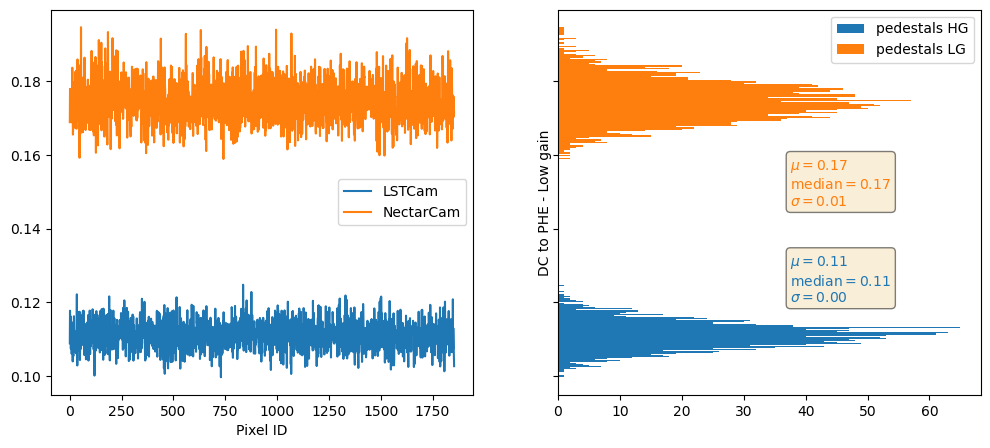

In [17]:
# no cycle over events since we already have a good event from the previous cell
triggered_telescopes = np.asarray(list(event.r0.tels_with_data))
if (triggered_telescopes > 5).any() and (triggered_telescopes < 5).any():
    lst_found = 0
    for tel_id in triggered_telescopes:
        cam_id = event.inst.subarray.tel[tel_id].camera.cam_id
        pix_ids = event.inst.subarray.tel[tel_id].camera.pix_id
        dc_to_pe = event.mc.tel[tel_id].dc_to_pe
        if (lst_found == 1) and (cam_id == "LSTCam"):
            continue
        elif (lst_found == 0) and (cam_id == "LSTCam"):
            lst_found = 1
            dc_to_pe_channels_lst = dc_to_pe
        elif (lst_found == 1) and (cam_id == "NectarCam"):
            dc_to_pe_channels_mst = dc_to_pe
            break
# plot channel-wise
for i, gain in enumerate(["High", "Low"]):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), tight_layout=False, sharey=True)
    ax1.set_xlabel("Pixel ID")
    ax2.set_ylabel(f"DC to PHE - {gain} gain")
    p1 = ax1.plot(pix_ids, dc_to_pe_channels_lst[i], label="LSTCam")
    p2 = ax1.plot(pix_ids, dc_to_pe_channels_mst[i], label="NectarCam")
    ax2.hist(dc_to_pe_channels_lst[i], bins = 100, orientation="horizontal", label="pedestals HG")
    add_stats(dc_to_pe_channels_lst[i], ax2, x = 0.55, y = 0.30, color = p1[0].get_color())
    ax2.hist(dc_to_pe_channels_mst[i], bins = 100, orientation="horizontal", label="pedestals LG")
    add_stats(dc_to_pe_channels_mst[i], ax2, x = 0.55, y = 0.55, color = p2[0].get_color())
    ax1.legend()
    ax2.legend()
    fig.savefig(f"./plots_calibration/dcTophe{gain}GainVSpixelids_LSTCam+NectarCam_protopipe_{config}.png")

### Correlation between the reconstructed and true number of photoelectrons

In [18]:
# filter positive number of photoelectrons (because it's a log-log plot)
good_values_mst = np.where((mc_mst>0) & (dl1_mst>0))
good_values_lst = np.where((mc_lst>0) & (dl1_lst>0))
# combine cameras
mc = [mc_lst[good_values_lst], mc_mst[good_values_mst]]
reco = [dl1_lst[good_values_lst], dl1_mst[good_values_mst]]
# filter also weights
weights = [weights_lst[good_values_lst], weights_mst[good_values_mst]]

Total number of events in the plot of LSTCam (before re-weighting) = 1263603.0
Total number of events in the plot of NectarCam (before re-weighting) = 1418139.0


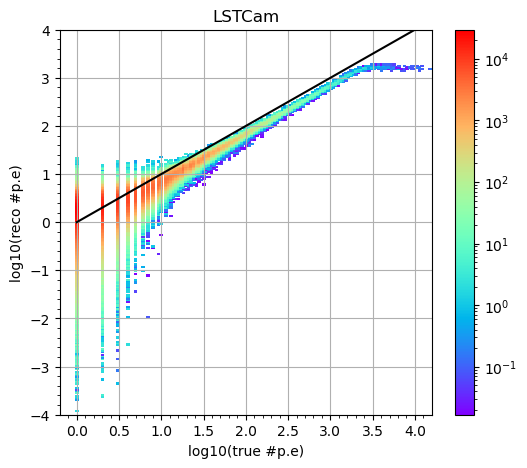

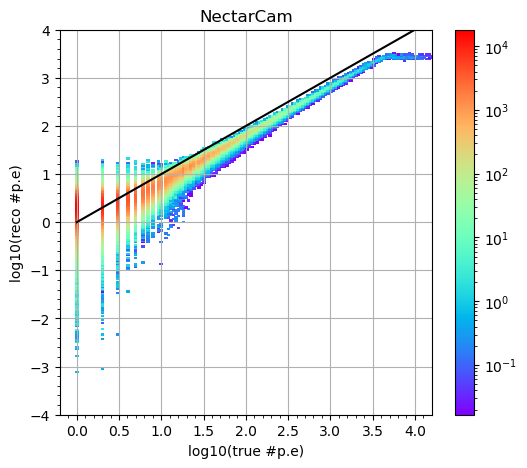

In [19]:
nbins_x = 400
nbins_y = 400
cameras = ["LSTCam", "NectarCam"] # this could go up, where data is loaded so in the future it reads automaically

for camera_index in range(len(cameras)):
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(cameras[camera_index])
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("log10(reco #p.e)")
    
    # This is just to count the real number of events given to the histogram
    h_no_weights = plt.hist2d(np.log10(mc[camera_index]), np.log10(reco[camera_index]),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,5.],[-7.,5.]],
                   norm=LogNorm(),
                  )
    
    # This histogram has the weights applied, so the number of events there is biased by this
    # This is what is plot
    h = plt.hist2d(np.log10(mc[camera_index]), np.log10(reco[camera_index]),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,5.],[-7.,5.]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[camera_index],
                  )
    
    plt.plot([0, 4], [0, 4], color="black") # line showing perfect correlation
    plt.minorticks_on()
    plt.xticks(ticks=np.arange(-1, 5, 0.5), labels=["",""]+[str(i) for i in np.arange(0, 5, 0.5)])
    plt.xlim(-0.2,4.2)
    plt.ylim(-4.,4.)
    plt.colorbar(h[3], 
                 ax=plt.gca()
                )
    plt.grid()
    
    fig.savefig(f"./plots_calibration/recoPhesVsTruePhes_{cameras[camera_index]}_protopipe_{config}.png")
    
    # Print some debug/benchmarking information
    print(f"Total number of events in the plot of {cameras[camera_index]} (before re-weighting) = {h_no_weights[0].sum()}")

### Charge resolution

In [20]:
# First restore reconstructed negative values, since now we take ratios, instead of logarithms
# filter only positive number of true photoelectrons
good_values_lst = np.where(mc_all[0]>0)
good_values_mst = np.where(mc_all[1]>0)
# combine cameras
mc = [mc_all[0][good_values_lst], mc_all[1][good_values_mst]]
reco = [reco_all[0][good_values_lst], reco_all[1][good_values_mst]]
weights = [weights_all[0][good_values_lst], weights_all[1][good_values_mst]]

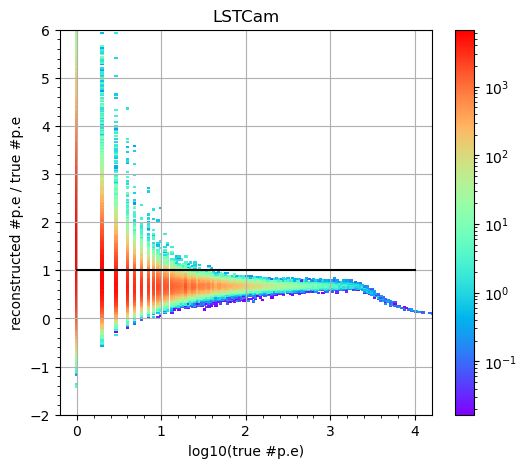

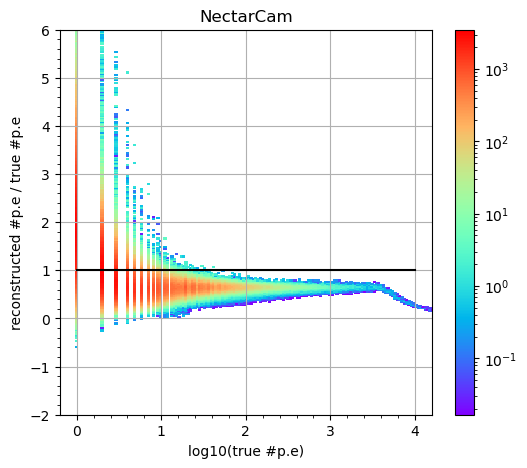

In [21]:
nbins_x = 800
nbins_y = 600

histogram = [] # camera-wise un-zoomes histogram for calculating bias later on

for camera_index in range(len(cameras)):
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(cameras[camera_index])
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("reconstructed #p.e / true #p.e")
    
    h = plt.hist2d(np.log10(mc[camera_index]), (reco[camera_index]/mc[camera_index]),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,15.],[-2,13]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[camera_index],
                  )
    
    histogram.append(h)
    
    plt.plot([0, 4], [1, 1], color="black") # line showing perfect correlation
    plt.colorbar(h[3], ax=plt.gca()
                 #, format=ticker.FuncFormatter(fmt)
                )
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor')
    plt.grid()
    plt.xlim(-0.2,4.2)
    plt.ylim(-2.,6.)

    fig.savefig(f"./plots_calibration/chargeResolution_1stPass_{cameras[camera_index]}_protopipe_{config}.png")

### Calculation of the average bias for each camera

In [22]:
corr = []
print(f"Correction factors for average bias : ")
for camera_index in range(len(cameras)):
    corr.append(calc_bias(histogram[camera_index][1], histogram[camera_index][2], histogram[camera_index][0]))
    print(f"- {cameras[camera_index]} = {corr[camera_index]:.2f}")

Correction factors for average bias : 
- LSTCam = 1.46
- NectarCam = 1.53


### Charge resolution corrected for average bias

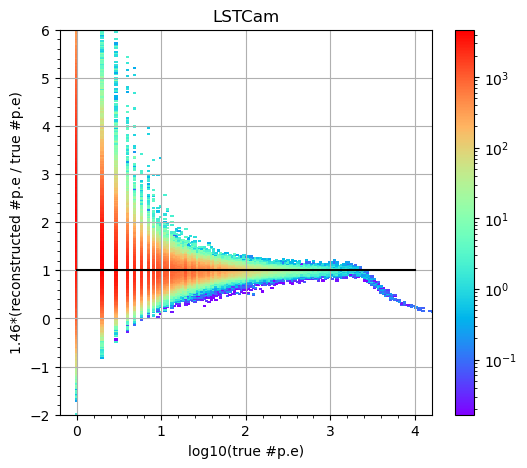

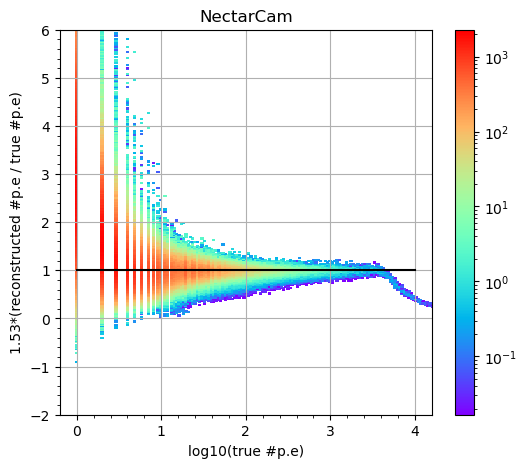

In [23]:
nbins_x = 800
nbins_y = 600

histogram = [] # camera-wise un-zoomes histogram for calculating RMS later on

for camera_index in range(len(cameras)):
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(cameras[camera_index])
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("{:.2f}*(reconstructed #p.e / true #p.e)".format(corr[camera_index]))
    
    h = plt.hist2d(np.log10(mc[camera_index]), corr[camera_index]*(reco[camera_index]/mc[camera_index]),
                   bins=[nbins_x, nbins_y],
                   range=[[-7.,15.],[-2,13]],
                   norm=LogNorm(),
                   cmap=plt.cm.rainbow,
                   weights=weights[camera_index],
                  )
    
    histogram.append(h)
    
    plt.plot([0, 4], [1, 1], color="black") # line showing perfect correlation
    plt.colorbar(h[3], ax=plt.gca()
                 #, format=ticker.FuncFormatter(fmt)
                )
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor')
    plt.grid()
    plt.xlim(-0.2,4.2)
    plt.ylim(-2.,6.)

    fig.savefig(f"./plots_calibration/chargeResolution_1stPass_{cameras[camera_index]}_protopipe_{config}.png")

### RMS of charge resolution (around 1)

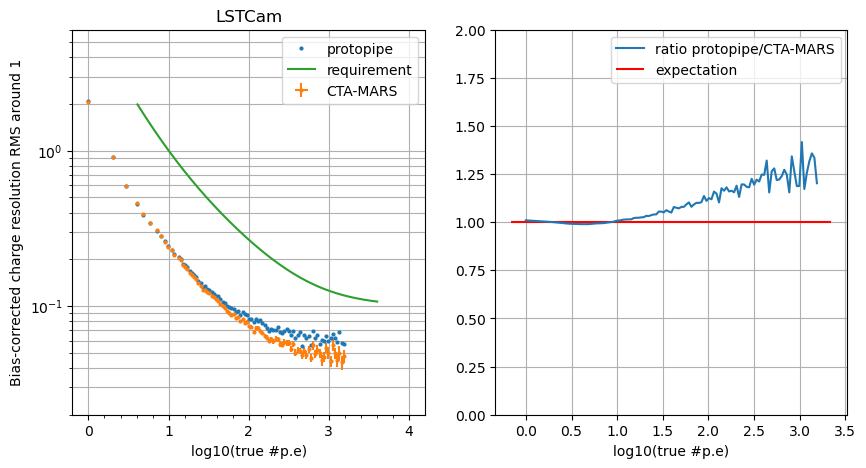

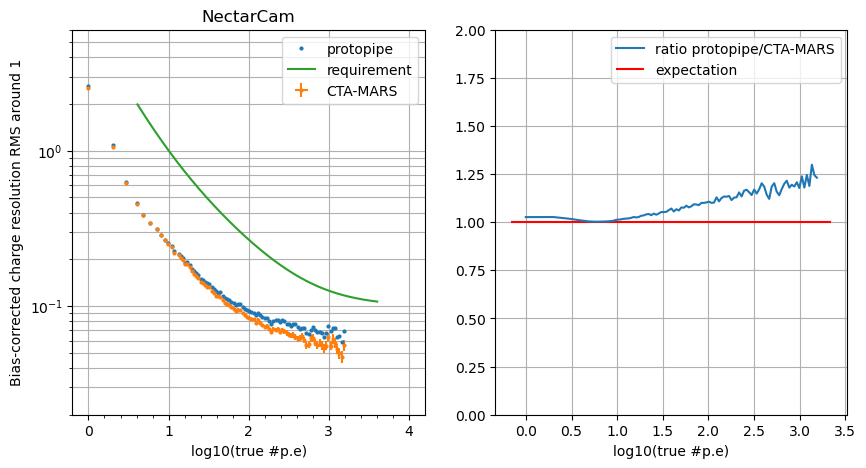

In [24]:
for camera_index in range(len(cameras)):
    
    fig = plt.figure(figsize=(10,5), tight_layout=False)
    
    plt.subplot(1,2,1)

    bin_edges_true = histogram[camera_index][1]
    bincenters_true = 0.5*(bin_edges_true[1:]+bin_edges_true[:-1]) # mean value of each bin in true photoelectrons
    bin_edges_y = histogram[camera_index][2] # bin edges in reconstructed photoelectrons
    bincenters_y = 0.5*(bin_edges_y[1:]+bin_edges_y[:-1]) # mean value of each bin in reconstructed photoelectrons

    # cycle over bins in true photoelectrons:
    values = []
    errors = []
    n = 0
    ref = []
    for true_bin in range(len(bincenters_true)):
        # if the bin center is over 3.2
        if (bincenters_true[true_bin] > 3.2):
            break # stop
        # if it's before -0.5
        if (bincenters_true[true_bin] < -0.5):
            continue # check the next bin
        # else proceed with the calculation
        # take the profile at this X bin along the Y axis
        profile_y = histogram[camera_index][0][true_bin] # this is the sequence of weights (aka the heights of the 600 bins)
        # if there is data falling in this X-axis bin,
        if np.sum(profile_y):
            ref.append(true_bin)
            # get the resolution the way Abelardo does
            # to do this we need also the bin centers along the Y axis
            result = calc_rms(bincenters_y, profile_y)
            values.append(result)

            # error bars TO DO

            n = n + 1
        else: # otherwise go to the next bin in true photoelectrons
            continue

    values = np.asarray(values)
    # errors = np.asarray(errors)

    # protopipe
    plt.plot(bincenters_true[ref], values, 'o', markersize=2, label="protopipe")
    # plt.errorbar(bincenters_true[ref], values, yerr=errors, fmt='o',markersize=2, label="protopipe")
    
    # CTA-MARS
    rms[camera_index].matplotlib(fmt="o", markersize=2, label="CTA-MARS")

    plt.yscale("log")
    plt.ylim(0.02,6)
    plt.xlim(-0.2,4.2)

    # superimose requirement converted in p.e. from abelardo script
    plt.plot(np.log10(photons), req, label="requirement")

    plt.grid(which='both', axis='y')
    plt.grid(which='major', axis='x')
    plt.minorticks_on()
    plt.legend()
    
    plt.title(cameras[camera_index])
    plt.xlabel("log10(true #p.e)")
    plt.ylabel("Bias-corrected charge resolution RMS around 1")
    
    plt.subplot(1,2,2)
    
    plt.plot(rms[camera_index].xvalues, values/rms[camera_index].yvalues, label="ratio protopipe/CTA-MARS")
    ax = plt.gca()
    xlims=ax.get_xlim()
    plt.hlines(1., xlims[0], xlims[1], label="expectation", color='r')
    plt.ylim(0, 2)
    plt.grid()
    plt.legend()
    plt.xlabel("log10(true #p.e)")

    plt.show()

**Note:** the requirement is placed only for completness, but it's not directly comparable to the data - see the *Requirements* section.

### Single-pixel spectrum

In [25]:
# filter positive number of photoelectrons (for log-log plots)
# good_values_lst_1stPass = np.where((mc_all[0]>0) & (reco_all[0]>0))
# good_values_mst_1stPass = np.where((mc_all[1]>0) & (reco_all[1]>0))
good_values_lst_1stPass = np.where(reco_all[0]>0)
good_values_mst_1stPass = np.where(reco_all[1]>0)
# 2nd pass also needs the 'calibration_status' variable
# if 0 the image didn't survive the preliminary cleaning and the 2nd pass is null
# good_values_lst_2ndPass = np.where((mc_all[0]>0) & (reco_2ndPass_all[0]>0) & (calibration_status_lst == 1))
# good_values_mst_2ndPass = np.where((mc_all[1]>0) & (reco_2ndPass_all[1]>0) & (calibration_status_mst == 1))
good_values_lst_2ndPass = np.where((reco_2ndPass_all[0]>0) & (calibration_status_lst == 1))
good_values_mst_2ndPass = np.where((reco_2ndPass_all[1]>0) & (calibration_status_mst == 1))
# combine cameras
# mc_1stPass = [mc_all[0][good_values_lst_1stPass], mc_all[1][good_values_mst_1stPass]]
# mc_2ndPass = [mc_all[0][good_values_lst_2ndPass], mc_all[1][good_values_mst_2ndPass]]
reco_1stPass = [reco_all[0][good_values_lst_1stPass], reco_all[1][good_values_mst_1stPass]]
reco_2ndPass = [reco_2ndPass_all[0][good_values_lst_2ndPass], reco_2ndPass_all[1][good_values_mst_2ndPass]]

LSTCam: cutting at ~4.20665 (biased) photoelectrons rejects 99.7% of the noise and saves 66.4% of the signal
NectarCam: cutting at ~3.99917 (biased) photoelectrons rejects 99.7% of the noise and saves 65.5% of the signal


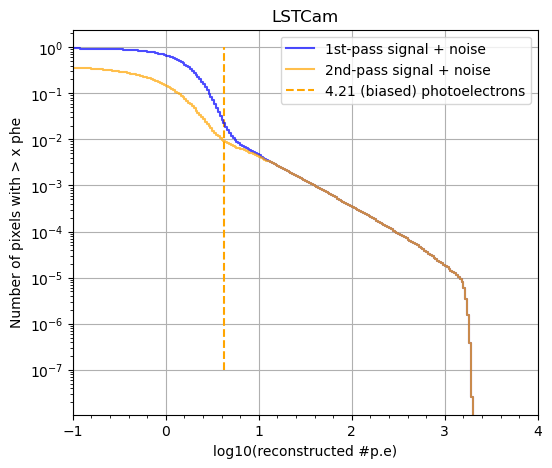

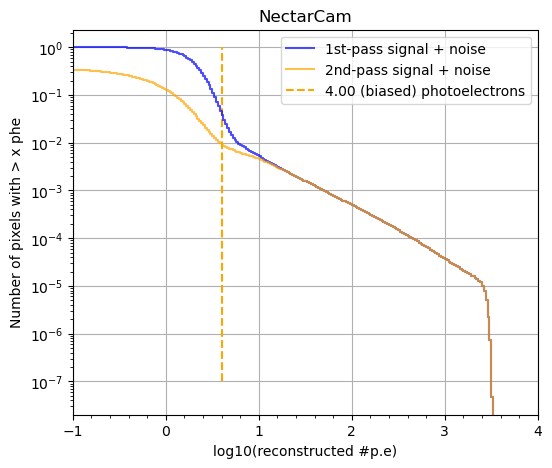

In [26]:
nbins = 250
xrange = [-1,4]

core_thresholds = []

for camera_index in range(len(cameras)):
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    
    plt.title(cameras[camera_index])
    plt.xlabel("log10(reconstructed #p.e)")
    plt.ylabel("Number of pixels with > x phe")

    # all the original simulated events
    t = mc_all[camera_index]
    tot_entries = len(t) # events * telescopes * pixels
    # 1st pass: no cut, all 1st pass images are saved by the image extractor TwoPassWindowSum
    # 2nd pass: only images which survived 1st pass and which preliminary image fit was non-patological
    t_2ndPass = t[np.where((reco_2ndPass_all[camera_index]>0) & (calibration_status_all[camera_index] == 1))]
    
    # Since we are working only with simulated data,
    # "signal" is when a pixel has at least 1 simulated photoelectron
    # "noise"  is when a pixel has no simulated photoelectron
    signal_2ndPass = reco_2ndPass[camera_index][np.where(t_2ndPass>0)]
    noise_2ndPass = reco_2ndPass[camera_index][np.where(t_2ndPass==0)]
    
    # Plot 1st-Pass
    
    hist_1, xbins_1 = np.histogram(np.log10(reco_1stPass[camera_index]), bins=nbins, range=xrange)
    plt.semilogy(xbins_1[:-1], hist_1[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post",alpha=0.7, label="1st-pass signal + noise", color='blue')
    
    # Plot 2nd-Pass
    
    hist_2, xbins_2 = np.histogram(np.log10(reco_2ndPass[camera_index]), bins=nbins, range=xrange)
    plt.semilogy(xbins_2[:-1], hist_2[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post",alpha=0.7, label="2nd-pass signal + noise", color='orange')

    # common style options
    plt.xlim(xrange)
    plt.minorticks_on()
    plt.grid()
    plt.legend()
    
    # Print info about threshold cuts
    # This is information related to 2nd pass (the one that ends up into image cleaning)
    
    # This is the cut in (biased) photoelectrons that rejects 99.7% of the "noise"
    cut = np.quantile(noise_2ndPass, 0.997)
    core_thresholds.append(cut)
    signal_saved = percentileofscore(signal_2ndPass, cut)
    plt.vlines(np.log10(cut), ymin=1.e-7, ymax=1, color='orange', linestyle="--", label=f"{cut:.2f} (biased) photoelectrons")
    
    plt.legend()
    
    print(f"{cameras[camera_index]}: cutting at ~{cut:.5f} (biased) photoelectrons rejects 99.7% of the noise and saves {signal_saved:.1f}% of the signal")

    fig.savefig(f"./plots_calibration/singlePixelSpectrum_{cameras[camera_index]}_protopipe_{config}.png")

### Get optimized image cleaning thresholds

In [35]:
print("Optimized BIASED image cleaning thresholds for:")
for camera_index in range(len(cameras)):
    optimized_core_threshold = core_thresholds[camera_index]
    optimized_boundary_threshold = optimized_core_threshold/2.
    print(f" - {cameras[camera_index]}: ({optimized_core_threshold:.2f},{optimized_boundary_threshold:.2f})"
          f"--> ({int(round(optimized_core_threshold))}, {int(round(optimized_boundary_threshold))})")

print("\nWARNING: since the pipeline doesn't know about the residual bias calculated before,")
print("you need to use the BIASED units to setup the image cleaning")
print("(i.e. the values to be put in the analysis configuration file of protopipe)\n")
    
print("Optimized UNBIASED image cleaning thresholds for:")
for camera_index in range(len(cameras)):
    optimized_core_threshold = core_thresholds[camera_index] * corr[camera_index]
    optimized_boundary_threshold = optimized_core_threshold/2.
    print(f" - {cameras[camera_index]}: ({optimized_core_threshold:.2f},{optimized_boundary_threshold:.2f})"
          f"--> ({int(round(optimized_core_threshold))}, {int(round(optimized_boundary_threshold))})")
    
print("\nIf the pipeline corrected perfectly everything, you would expect the bias to be almost 0")
print("so the previous 2 sets of values should be very similar in that case.")

Optimized BIASED image cleaning thresholds for:
 - LSTCam: (4.21,2.10)--> (4, 2)
 - NectarCam: (4.00,2.00)--> (4, 2)

you need to use the BIASED units to setup the image cleaning
(i.e. the values to be put in the analysis configuration file of protopipe)

Optimized UNBIASED image cleaning thresholds for:
 - LSTCam: (6.12,3.06)--> (6, 3)
 - NectarCam: (6.13,3.07)--> (6, 3)

If the pipeline corrected perfectly everything, you would expect the bias to be almost 0
so the previous 2 sets of values should be very similar in that case.
